<a href="https://colab.research.google.com/github/ianuhs/FinSentiNet/blob/main/FinSentiNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Financial Sentiment Classification with Confidence Calibration Using Transformer-Based Neural Network for NLP

Tech Stack:


Python
* Core language for data handling, modeling, and metric visualization

PyTorch / CUDA
* Deep learning framework accelerated on GPU for model training, fine-tuning, temperature scaling, and optimization

DistilBERT
* Compact transformer‑based model (6 layers, 66M parameters) for NLP tasks

Hugging Face Transformers
* Pre-trained models, tokenization, and training/evaluation APIs

Dataset
* Financial PhraseBank
* Split dataset: train/validation/test (70/15/15)

Scikit-learn
* Stratified data splitting, evaluation metrics (accuracy, precision, recall, F1-score), and cross-entropy loss computation

NumPy
* Numerical computing for array operations in model processing, metrics, and data handling

Matplotlib
* Visualization of training curves, evaluation metrics, reliabilty diagrams, and entropy histograms

Temperature Scaling
* Post-processing technique that divides logits by a learned scalar temperature to calibrate softmax confidence scores without altering predictions

Softplus Function
* Activation function (smooth approximation of ReLU function) applied to temperature parameter to ensure positivity and enable gradient-based optimization

LBFGS Optimizer
* Limited-memory quasi-Newton optimizer used to minimize cross-entropy loss over temperature parameter

Negative Log Likelihood (NLL) Loss
* Loss function used during temperature fitting to penalize overconfident predictions and align probabilities with true labels

Entropy
* Measures uncertainty of predictions before and after temperature scaling to improve confidence calibration

ECE / MCE (Calibration Metrics)
* Expected and Maximum Calibration Error metrics that measure gap between predicted confidence and actual accuracy across confidence quantile bins




# Set Up


In [1]:
# Upgrades
!pip install --upgrade transformers datasets --quiet

# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from datasets import Value, ClassLabel

# Warning suppression
import warnings
import logging
warnings.filterwarnings("ignore")
logging.getLogger("transformers").setLevel(logging.ERROR)

# Hugging Face Transformers & Datasets
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding, EarlyStoppingCallback)
from datasets import Dataset, DatasetDict

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Retrieve data
file_paths = [
    '/content/Sentences_50Agree.txt',
    '/content/Sentences_66Agree.txt',
    '/content/Sentences_75Agree.txt',
    '/content/Sentences_AllAgree.txt'
]

texts = []
labels = []

for file_path in file_paths:
    with open(file_path, 'r', encoding='utf-8', errors='replace') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                # Split last occurrence of '@' to separate text and label
                text, label = line.rsplit('@', 1)
                texts.append(text)
                labels.append(label)
            except ValueError:
                print(f"Skipping malformed line in {file_path}: {line}")

# Convert to pandas DataFrame
df = pd.DataFrame({"text": texts, "label": labels})

# Map sentiment labels to integers
label_names = ["negative", "neutral", "positive"]
label_to_id = {label: i for i, label in enumerate(label_names)}
df["label_id"] = df["label"].map(label_to_id)
if df["label_id"].isnull().any():
    raise ValueError("Some labels in your dataset do not match label_names!")
df["label_id"] = df["label_id"].astype(int)

# Split into train, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df["label_id"])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df["label_id"])

# Convert to Hugging Face DatasetDict
dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df, preserve_index=False),
    "validation": Dataset.from_pandas(val_df, preserve_index=False),
    "test": Dataset.from_pandas(test_df, preserve_index=False)
})

print(dataset)

# Tokenizer & data collator
MODEL_CHECKPOINT = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

def tokenize_function(batch):
    tokenized = tokenizer(batch["text"], truncation=True, padding=True)
    tokenized["labels"] = batch["label_id"]
    return tokenized

tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=["text", "label", "label_id"])
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_id'],
        num_rows: 10346
    })
    validation: Dataset({
        features: ['text', 'label', 'label_id'],
        num_rows: 2217
    })
    test: Dataset({
        features: ['text', 'label', 'label_id'],
        num_rows: 2217
    })
})


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/10346 [00:00<?, ? examples/s]

Map:   0%|          | 0/2217 [00:00<?, ? examples/s]

Map:   0%|          | 0/2217 [00:00<?, ? examples/s]

# Model 1: Baseline Model

* batch size: 32
* learning rate: 2e-5
* weight decay: 0.01
* epochs: 10


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.374900,0.200230,0.930988,0.933402,0.930988,0.931561
2,0.128100,0.147170,0.956698,0.956847,0.956698,0.956684
3,0.060300,0.129106,0.967073,0.967280,0.967073,0.967016
4,0.030100,0.133877,0.972936,0.973014,0.972936,0.972833
5,0.015200,0.142578,0.974741,0.974783,0.974741,0.974758
6,0.011500,0.154213,0.974290,0.974288,0.974290,0.974211
7,0.008300,0.146127,0.974290,0.974293,0.974290,0.974291
8,0.004600,0.152560,0.974290,0.974360,0.974290,0.974316
9,0.003300,0.154955,0.974290,0.974278,0.974290,0.974282
10,0.002900,0.155561,0.973839,0.973821,0.973839,0.973827



=== Baseline Model Validation Metrics ===
eval_loss: 0.1426
eval_accuracy: 0.9747
eval_precision: 0.9748
eval_recall: 0.9747
eval_f1: 0.9748
eval_runtime: 7.6697
eval_samples_per_second: 289.0580
eval_steps_per_second: 9.1270
Weighted ROC-AUC: 0.9907


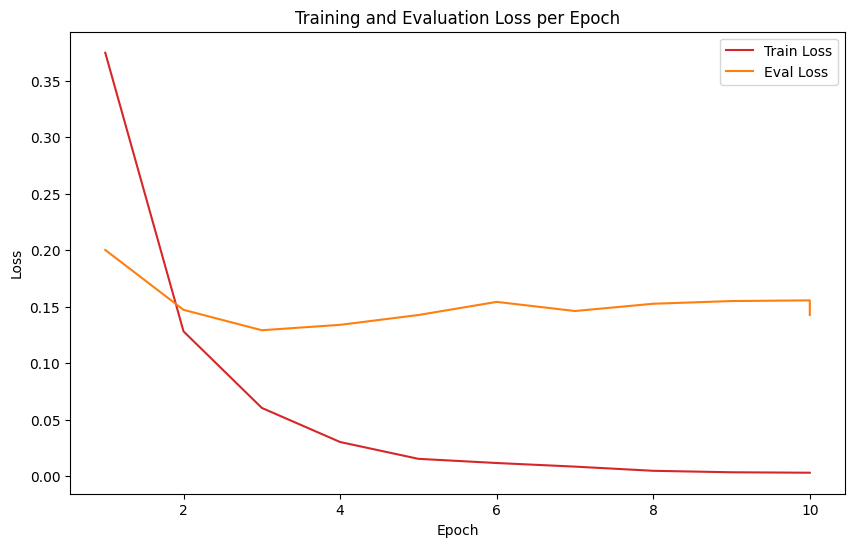

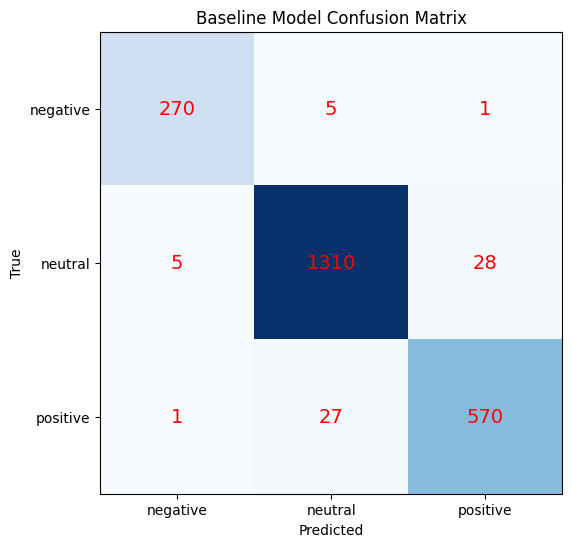

In [ ]:
# Load DistilBERT
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_CHECKPOINT,
    num_labels = len(label_names)  # label_names = ["negative", "neutral", "positive"]
).to(device)  # Move model to GPU

# Define metric function for Hugging Face Trainer
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# Training arguments for Hugging Face Trainer
training_args = TrainingArguments(
    output_dir="./phase1_baseline",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32, # For T4 GPU memory
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
    disable_tqdm=True
)

# Initialize Hugging Face Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Train model
trainer.train()

# Evaluate on validation set
eval_results = trainer.evaluate()
print("\n=== Baseline Model Validation Metrics ===")
for k, v in eval_results.items():
    if k.startswith("eval_"):
        print(f"{k}: {v:.4f}")

# Performance Metrics and Visuals

log_history = trainer.state.log_history

train_epochs, train_loss = [], []
eval_epochs, eval_loss = [], []

for log in log_history:
    if 'loss' in log:
        train_epochs.append(log.get('epoch'))
        train_loss.append(log.get('loss'))
    if 'eval_loss' in log:
        eval_epochs.append(log.get('epoch'))
        eval_loss.append(log.get('eval_loss'))

# Predictions for test set
preds_output = trainer.predict(tokenized_dataset["test"])
preds = np.argmax(preds_output.predictions, axis=-1)
labels = preds_output.label_ids

# ROC-AUC (multi-class, one-vs-rest)
labels_binarized = label_binarize(labels, classes=list(range(len(label_names))))
preds_proba = torch.nn.functional.softmax(torch.tensor(preds_output.predictions), dim=1).numpy()
roc_auc = roc_auc_score(labels_binarized, preds_proba, average="weighted", multi_class="ovr")
print(f"Weighted ROC-AUC: {roc_auc:.4f}")

# Plot training and evaluation loss
plt.figure(figsize=(10,6))
plt.plot(train_epochs, train_loss, label="Train Loss", color="tab:red")
plt.plot(eval_epochs, eval_loss, label="Eval Loss", color="tab:orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss per Epoch")
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(labels, preds)
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(cm, cmap="Blues")
ax.set_xticks(range(len(label_names)))
ax.set_yticks(range(len(label_names)))
ax.set_xticklabels(label_names)
ax.set_yticklabels(label_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Baseline Model Confusion Matrix")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="red", fontsize=14)
plt.show()

# Model 2: Improved Model

* batch size: 32
* initial learning rate: 2e-5
* learning rate scheduler: cosine
* warmup ratio: 0.1
* weight decay: 0.02
* epochs: 25
* early stop: if eval F1 does not increase in 3 epochs

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

{'loss': 0.7528, 'grad_norm': 5.741649627685547, 'learning_rate': 7.975308641975308e-06, 'epoch': 1.0}
{'eval_loss': 0.34409940242767334, 'eval_accuracy': 0.8881371222372576, 'eval_precision': 0.8883843843117675, 'eval_recall': 0.8881371222372576, 'eval_f1': 0.8868658633930261, 'eval_runtime': 7.1031, 'eval_samples_per_second': 312.117, 'eval_steps_per_second': 9.855, 'epoch': 1.0}
{'loss': 0.2468, 'grad_norm': 1.6411148309707642, 'learning_rate': 1.5975308641975308e-05, 'epoch': 2.0}
{'eval_loss': 0.19882456958293915, 'eval_accuracy': 0.9282814614343707, 'eval_precision': 0.931615221615465, 'eval_recall': 0.9282814614343707, 'eval_f1': 0.929008357350271, 'eval_runtime': 7.1777, 'eval_samples_per_second': 308.872, 'eval_steps_per_second': 9.752, 'epoch': 2.0}
{'loss': 0.1325, 'grad_norm': 0.26525720953941345, 'learning_rate': 1.9975940188661406e-05, 'epoch': 3.0}
{'eval_loss': 0.12464237958192825, 'eval_accuracy': 0.9630130807397383, 'eval_precision': 0.9632004972959665, 'eval_recall':

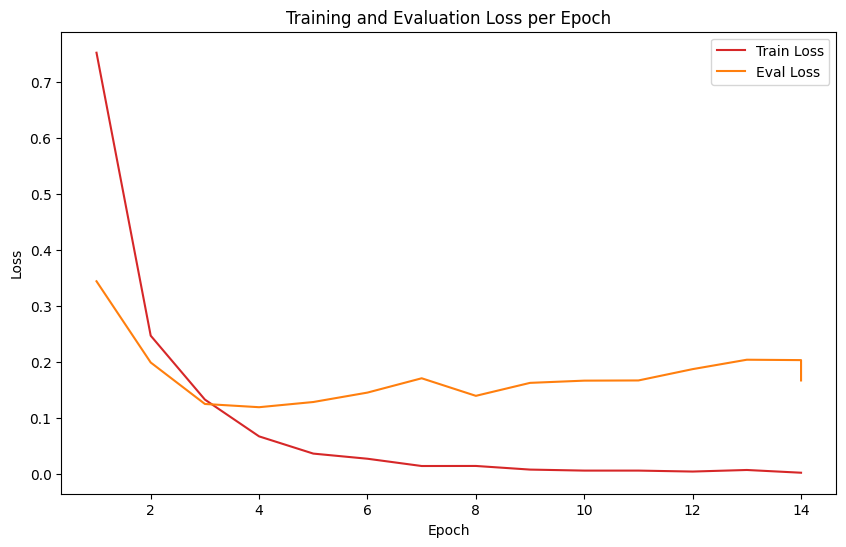

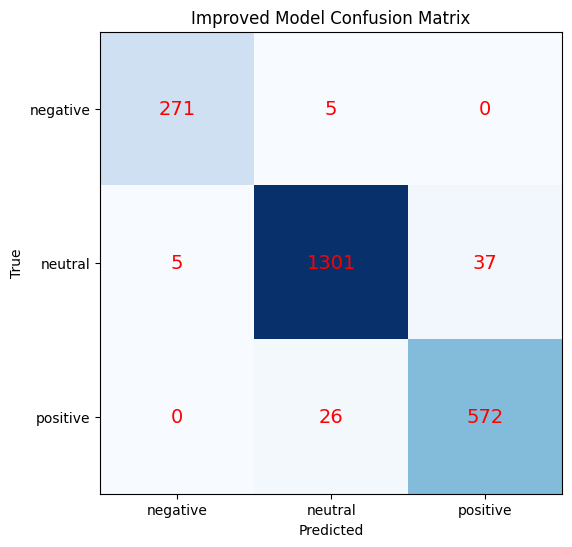

In [ ]:
# Load DistilBERT
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_CHECKPOINT,
    num_labels = len(label_names)  # label_names = ["negative", "neutral", "positive"]
).to(device)  # Move model to GPU

# Define metric function for Hugging Face Trainer
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# Training arguments for Hugging Face Trainer
training_args = TrainingArguments(
    output_dir="./phase1_baseline",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,
    per_device_train_batch_size=32, # For T4 GPU memory
    per_device_eval_batch_size=32,
    num_train_epochs=25,
    weight_decay=0.02,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

# Initialize Hugging Face Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# Train model
trainer.train()

# Evaluate on validation set
eval_results = trainer.evaluate()
print("\n=== Improved Model Validation Metrics ===")
for k, v in eval_results.items():
    if k.startswith("eval_"):
        print(f"{k}: {v:.4f}")


# Save model & tokenizer to drive
save_dir = "/content/drive/MyDrive"
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)


# Performance metrics and visuals
log_history = trainer.state.log_history

train_epochs, train_loss = [], []
eval_epochs, eval_loss = [], []

for log in log_history:
    if 'loss' in log:
        train_epochs.append(log.get('epoch'))
        train_loss.append(log.get('loss'))
    if 'eval_loss' in log:
        eval_epochs.append(log.get('epoch'))
        eval_loss.append(log.get('eval_loss'))

# Predictions for test set
preds_output = trainer.predict(tokenized_dataset["test"])
preds = np.argmax(preds_output.predictions, axis=-1)
labels = preds_output.label_ids

# Save predictions & labels (NumPy format)
np.save("model2_preds_output.npy", preds_output.predictions)
np.save("model2_labels.npy", labels)

# ROC-AUC (multi-class, one-vs-rest)
labels_binarized = label_binarize(labels, classes=list(range(len(label_names))))
preds_proba = torch.nn.functional.softmax(torch.tensor(preds_output.predictions), dim=1).numpy()
roc_auc = roc_auc_score(labels_binarized, preds_proba, average="weighted", multi_class="ovr")
print(f"Weighted ROC-AUC: {roc_auc:.4f}")

# Plot training and evaluation loss
plt.figure(figsize=(10,6))
plt.plot(train_epochs, train_loss, label="Train Loss", color="tab:red")
plt.plot(eval_epochs, eval_loss, label="Eval Loss", color="tab:orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss per Epoch")
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(labels, preds)
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(cm, cmap="Blues")
ax.set_xticks(range(len(label_names)))
ax.set_yticks(range(len(label_names)))
ax.set_xticklabels(label_names)
ax.set_yticklabels(label_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Improved Model Confusion Matrix")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="red", fontsize=14)
plt.show()

Model 2 Analysis

Improved metrics compared to Model 1: accuracy, precision, recall, F1 score

# Model 3: Confidence Calibration

**Goal:**
Improve reliability of Model 2 by calibrating confidence scores using temperature scaling, without changing predictions

**Tech and Strategy Terms:**
* Logits: raw, unnormalized outputs from a classification model representing class scores before softmax transformation
* Softmax: normalization function that converts logits into a probability distribution over classes
* Confidence: highest softmax probability for a given sample, representing model’s certainty in top prediction
* Stratified Splitting: data splitting technique that preserves class proportions across calibration and evaluation sets to ensure balanced representation
* Temperature Scaling: post-processing method that divides logits by a scalar temperature to adjust prediction confidence without changing predictions
* Softplus: smooth, differentiable function that ensures temperature remains positive and optimizable; defined as log(1 + exp(x))
* Quantile Binning: binning strategy that divides samples into bins with equal counts based on confidence values, improving stability in calibration metrics
* Cross-Entropy / NLL Loss: loss function that penalizes incorrect predictions based on predicted probability of true class; used to fit temperature parameter
* LBFGS: quasi-Newton optimization algorithm used for low-dimensional problems; used here to minimize loss over single temperature parameter
* ECE (Expected Calibration Error): weighted average gap between predicted confidence and actual accuracy across confidence bins
* MCE (Maximum Calibration Error): largest gap between confidence and accuracy observed across all bins
* Entropy: measure of uncertainty in predicted probability distribution; higher entropy indicates less confident predictions

**Process:**
1. Load logits and labels from Model 2
2. Split data into calibration (25%) and evaluation (75%) sets using stratified sampling
3. Fit temperature on calibration set by minimizing cross-entropy loss using LBFGS optimizer
4. Apply temperature to evaluation logits and compute softmax probabilities
5. Evaluate calibration using log loss, ECE, MCE, and entropy
6. Visualize results with reliability diagrams and entropy histograms

**Hypothesis:**
Applying temperature scaling will reduce overconfidence, lower calibration errors (ECE, MCE), improve log loss and increase accurate probability estimates without affecting classification accuracy.





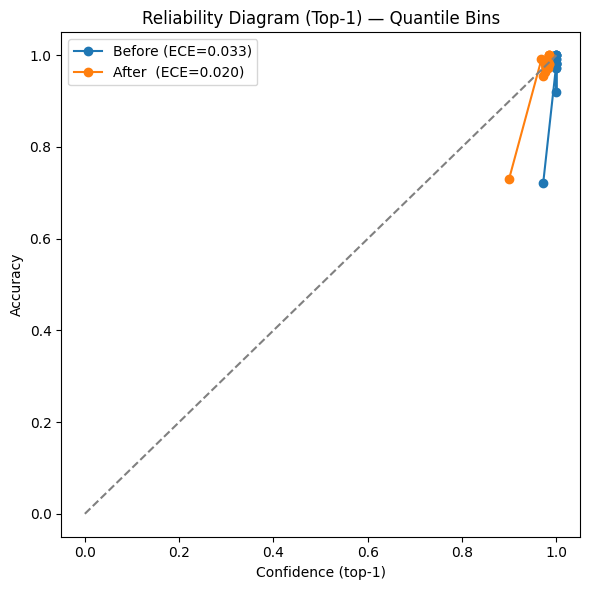

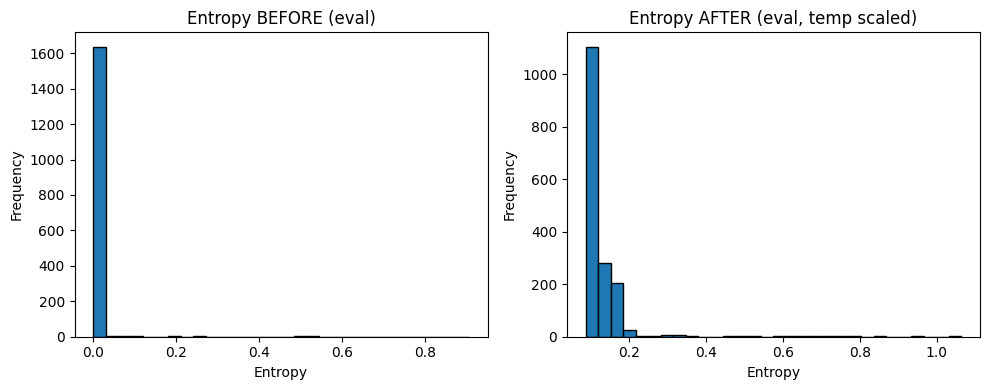


 === Model 3 Summary ===
Number of logits and classes: (2217, 3)
Number of labels: (2217,)
Calibration samples: 554 | Evaluation samples: 1663
Evaluation samples: 1663

Optimized Temperature = 2.344695

Log Loss before: 0.274774  -> after: 0.142922
Delta Log Loss = -0.131852
ECE before: 0.032970  -> after: 0.020334
Delta ECE = -0.012636
MCE before: 0.251164  -> after: 0.169746
Delta MCE = -0.081418


In [4]:
# Model-3: Temperature Scaling

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import log_loss
import math

# 1) Load Model 2 data
drive_path = "/content/drive/MyDrive/FinSentiNet_model2"
logits_all = np.load(os.path.join(drive_path, "model2_preds_output.npy"))
labels_all = np.load(os.path.join(drive_path, "model2_labels.npy"))
num_classes = logits_all.shape[1]

# Split data (25% calibration and 75% evaluation)
cal_frac = 0.25
eval_frac = 0.75
sss = StratifiedShuffleSplit(n_splits=1, test_size=eval_frac, random_state=42)
cal_idx, eval_idx = next(sss.split(np.zeros(len(labels_all)), labels_all))

logits_cal = logits_all[cal_idx]
y_cal = labels_all[cal_idx]

logits_eval = logits_all[eval_idx]
y_eval = labels_all[eval_idx]


# Temperature scaling class
"""
Goal: Find best temp that scales logits to calibrate prediction confidence
1) Initialize temp using inverse softplus of initial temp
2) Apply softplus to temp to ensure positive temp and enable gradient optimization
3) Compute best temp during forward pass
4) Scale logits by dividing best temp to calibrate softmax probabilities
"""
class TemperatureScaler(torch.nn.Module):
    def __init__(self, init_T: float = 1.0):
        super().__init__()
        init_val = float(init_T)
        if init_val < 1e-3:
            init_val = 1e-3
        inv_softplus = math.log(math.exp(init_val) - 1.0)
        self.log_T = torch.nn.Parameter(torch.tensor(inv_softplus, dtype=torch.float32))

    def T(self) -> torch.Tensor:
        return torch.nn.functional.softplus(self.log_T) + 1e-6

    def forward(self, logits: torch.Tensor) -> torch.Tensor:
        return logits / self.T()

# Optimize temp to calibrate logits by minimizing cross-entropy with LBFGS
def fit_temperature(logits_np: np.ndarray, labels_np: np.ndarray, init_T: float = 1.5, max_iter: int = 100):

    device = torch.device("cpu")
    logits = torch.tensor(logits_np, dtype=torch.float32, device=device)
    labels = torch.tensor(labels_np, dtype=torch.long, device=device)

    # Initialize temp and LBFGS optimizer for log_T
    scaler = TemperatureScaler(init_T=init_T).to(device)
    optimizer = torch.optim.LBFGS([scaler.log_T], lr=1.0, max_iter=max_iter, line_search_fn="strong_wolfe")
    criterion = torch.nn.CrossEntropyLoss()

    # Compute loss and gradients for log_T
    def closure():
        optimizer.zero_grad()
        scaled_logits = scaler(logits)
        loss = criterion(scaled_logits, labels)
        loss.backward() #backpropagation!
        return loss

    optimizer.step(closure)
    return scaler

scaler = fit_temperature(logits_cal, y_cal, init_T=1.5, max_iter=100)
best_T = scaler.T().item()

# Apply best temp to eval logits and get probabilities (before/after)
with torch.no_grad():
    logits_eval_t = torch.tensor(logits_eval, dtype=torch.float32)
    probs_eval_before = torch.softmax(logits_eval_t, dim=1).numpy()
    logits_eval_scaled = scaler(logits_eval_t)
    probs_eval_after  = torch.softmax(logits_eval_scaled, dim=1).numpy()

# Log loss (NLL) on evaluation split (before/after)
ll_before = log_loss(y_eval, probs_eval_before)  # sklearn's log_loss works for multiclass
ll_after  = log_loss(y_eval, probs_eval_after)

# ECE & MCE (top-1 confidences) using quantile bins
def compute_ece_mce(confidences, correctness, n_bins=15, quantile=True):

    N = len(confidences)
    if quantile:
        edges = np.quantile(confidences, np.linspace(0, 1, n_bins + 1))
        edges[0] = 0.0
        edges[-1] = 1.0000001
    else:
        edges = np.linspace(0.0, 1.0, n_bins + 1)

    ece = 0.0
    mce = 0.0
    bin_conf_means = []
    bin_acc_means = []

    for i in range(n_bins):
        left, right = edges[i], edges[i + 1]
        mask = (confidences > left) & (confidences <= right)
        if not np.any(mask):
            continue
        conf_mean = confidences[mask].mean()
        acc_mean = correctness[mask].mean()
        gap = abs(acc_mean - conf_mean)
        weight = mask.sum() / N
        ece += gap * weight
        mce = max(mce, gap)
        bin_conf_means.append(conf_mean)
        bin_acc_means.append(acc_mean)

    return ece, mce, np.array(bin_conf_means), np.array(bin_acc_means)

# Arrays for ECE/MCE and reliability
conf_eval_before = probs_eval_before.max(axis=1)  # Top-1 confidence before
preds_eval_before = probs_eval_before.argmax(axis=1)
correct_eval_before = (preds_eval_before == y_eval).astype(float)

conf_eval_after = probs_eval_after.max(axis=1)    # Top-1 confidence after
preds_eval_after = probs_eval_after.argmax(axis=1)
correct_eval_after = (preds_eval_after == y_eval).astype(float)

# Check if predictions are the same before and after scaling
preds_before = probs_eval_before.argmax(axis=1)
preds_after  = probs_eval_after.argmax(axis=1)

# Compute ECE/MCE
ece_before, mce_before, bc_before, ba_before = compute_ece_mce(conf_eval_before, correct_eval_before, n_bins=15, quantile=True)
ece_after,  mce_after,  bc_after,  ba_after  = compute_ece_mce(conf_eval_after,  correct_eval_after,  n_bins=15, quantile=True)

# Reliability diagrams
plt.figure(figsize=(6,6))
plt.plot(bc_before, ba_before, marker='o', linestyle='-', label=f"Before (ECE={ece_before:.3f})")
plt.plot(bc_after,  ba_after,  marker='o', linestyle='-', label=f"After  (ECE={ece_after:.3f})")
plt.plot([0,1], [0,1], '--', color='gray')  # perfect-calibration diagonal
plt.xlabel("Confidence (top-1)")
plt.ylabel("Accuracy")
plt.title("Reliability Diagram (Top-1) — Quantile Bins")
plt.legend()
plt.tight_layout()
plt.show()

# Entropy histograms
def entropy_of_probs(probs):
    p = np.clip(probs, 1e-12, 1.0)
    return -np.sum(p * np.log(p), axis=1)

entropy_before = entropy_of_probs(probs_eval_before)
entropy_after  = entropy_of_probs(probs_eval_after)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(entropy_before, bins=30, edgecolor='black')
plt.title("Entropy BEFORE (eval)")
plt.xlabel("Entropy")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
plt.hist(entropy_after, bins=30, edgecolor='black')
plt.title("Entropy AFTER (eval, temp scaled)")
plt.xlabel("Entropy")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Final summary
print("\n === Model 3 Summary ===")
print("Number of logits and classes:", logits_all.shape) # Number of logits and classes
print("Number of labels:", labels_all.shape) # Number of labels
print(f"Calibration samples: {len(y_cal)} | Evaluation samples: {len(y_eval)}\n")

print(f"Optimized Temperature = {best_T:.6f}\n")

print(f"Log Loss before: {ll_before:.6f}  -> after: {ll_after:.6f}")
print(f"Delta Log Loss = {(ll_after - ll_before):.6f}")
print(f"ECE before: {ece_before:.6f}  -> after: {ece_after:.6f}")
print(f"Delta ECE = {(ece_after - ece_before):.6f}")
print(f"MCE before: {mce_before:.6f}  -> after: {mce_after:.6f}")
print(f"Delta MCE = {(mce_after - mce_before):.6f}")

Model 3 Analysis

* Reliability diagram shows confidence closely matching accuracy after temperature scaling (orange points are closer to diagonal compared to blue points)
* Entropy histogram shows shift from extremely confident predictions (even when wrong) to more uncertainty which improves confidence reliability
* Temperature scaling (T = 2.34) on logits reduced overconfidence and did not change actual predictions, only the confidence
* Decrease in log loss (-0.132) suggests model's predicted probabilities are more accurate and less overconfident
* Decrease in ECE (-0.013) shows that average confidence is closer to actual accuracy
* Reduced worst-case confidence gap by 0.081
* Confidence is better aligned with correctness = probabilities are more trustworthy!